# Implementation of PUFEM for the Laplace Equation
Let $\Omega=(0,1)^2$ be the unit square.  
We will focus on solving the Laplace equation with Robin boundary conditions, i.e.
\begin{equation*} \begin{aligned} -\Delta u & = 0 \quad \text{in} \ \Omega, \\ -\frac{\partial u}{\partial n} &=\alpha(u-g_R) \quad \text{on} \ \Omega. \end{aligned} \end{equation*}

First we generate the mesh 

In [1]:
from import_hack import *
from methodsnm.mesh_2d import *
from methodsnm.visualize import *
N = 5
mesh = StructuredRectangleMesh(N,N)
h = 1.0/N
DrawMesh2D(mesh)

source module for methodsNM imported.


On the mesh we can define the partition of unity space:

In [2]:
from methodsnm.fes import *
from methodsnm.fe import PUFE
order = 2
fes = PUFE_Space(mesh,order=order) 
#fes = P3_Triangle_Space(mesh)


We can now visulize the PUFEM basis functions 

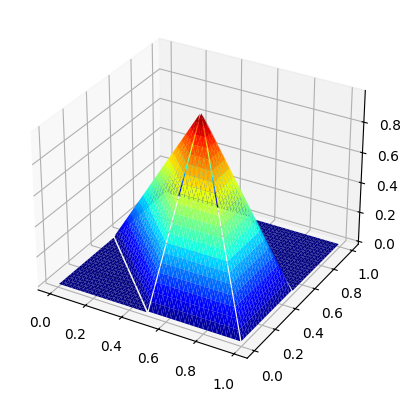

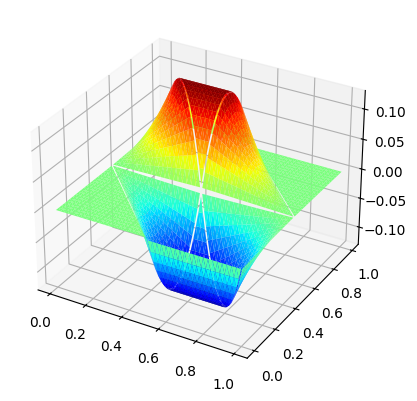

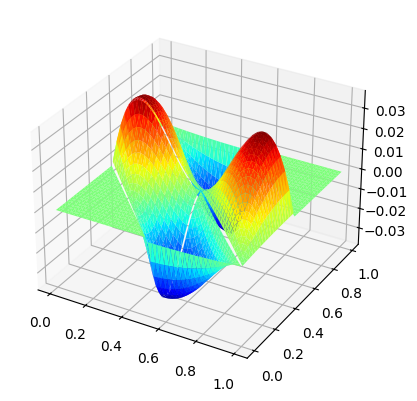

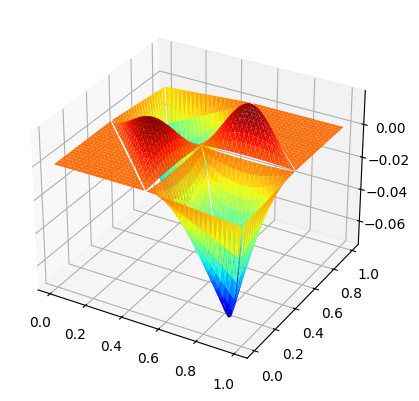

In [3]:
from methodsnm.fes import PUFE_Space
from methodsnm.meshfct import FEFunction
m = StructuredRectangleMesh(2, 2)
fes_basis = PUFE_Space(m,order= order)
uh = FEFunction(fes_basis)
for i in range(4*(2*order+1),5*(2*order+1)):
    uh.vector[:] = 0
    uh.vector[i] = 1
    DrawFunction2D(uh, sampling=20, shrink_eps=0.025, figsize=(5,4), contour=False)

Deriving the weak formulation we obtain:
\begin{equation*}
\int\limits_{\Omega} \nabla u \nabla v dx + \alpha \int\limits_{\partial \Omega}  u v ds
= \alpha \int\limits_{\partial \Omega} g_R v ds 
\end{equation*}
Here we chose the parameters
for $\partial \Omega = \Gamma_{north} \cup \Gamma_{south} \cup \Gamma_{west} \cup \Gamma_{east}$
\begin{equation*} \begin{aligned}
\alpha &= 1 \\
g_R&=0 \quad \text{on} \ \Gamma_{west}\\ 
g_R&=2\mathrm{e}\cos{(y)} \quad \text{on} \ \Gamma_{east}\\
g_R&=\mathrm{e}^{x} \quad \text{on} \ \Gamma_{south}\\
g_R&= \mathrm{e}^{x}(\cos{(1)}-\sin{(1)}) \quad \text{on} \ \Gamma_{north}\\
\end{aligned} \end{equation*}

In [4]:
from numpy import exp,cos,sin
def coeff_g(x):
    if x[0]<=1e-10:
        return 0
    elif x[0]>=1-1e-10:
        return 2*exp(1)*cos(x[1])
    elif x[1]<=1e-10:
        return exp(x[0])
    elif x[1]>=1-1e-10:
        return exp(x[0])*(cos(1)-sin(1))
    else:
        raise Exception('')

In the assembly of PUFEM we compute the stiffness matrix $A$ and the right hand side $b$.  
 For the linear system of eqautions 
$$Ax =b$$

In [5]:
from methodsnm.forms import *
from methodsnm.formint import *
from numpy import pi, cos, sin


blf = BilinearForm(fes)
c = GlobalFunction(lambda x: 1, mesh = mesh)
r = GlobalFunction(lambda x: 1, mesh = mesh)
blf+=LaplaceIntegral(c)
blf+=BoundaryMassIntegral(r) #r=alpha
blf.assemble()


lf = LinearForm(fes)
f = GlobalFunction(lambda x: 0, mesh = mesh)
lf += SourceIntegral(f)
g=GlobalFunction(coeff_g,mesh=mesh)
lf+= NeumannBoundary(g) #g=alpha*g_R
lf.assemble()

We can compare the numeber of degrees of freedom for FEM and PUFEM

In [6]:
from methodsnm.ndof import *
N_ndof = N
order_ndof = order 
print('ndofs for FEM                            :',FEM_ndof(N_ndof,order_ndof))
print('ndofs for PUFEM with harmonic polynomials:',PUFEM_harmonic_ndof(N_ndof,order_ndof))
print('ndofs for PUFEM with standard polynomials:',PUFEM_standard_poly_ndof(N_ndof,order_ndof))

ndofs for FEM                            : 121
ndofs for PUFEM with harmonic polynomials: 180
ndofs for PUFEM with standard polynomials: 216


In [7]:
plt.spy(blf.matrix, markersize=4*h)
print(blf.matrix.shape)

(180, 180)


We calculate the dimension of the kernel of the stiffness matrix, such that we can regularize the matrix if it is singular.

In [8]:
from numpy.linalg import eig
mat = blf.matrix.toarray()
vals,vect = eig(mat)
total = 0
for i in vals:
    if i<1e-14 and i>-1e-14:
        total += 1
print('dimension of the kernel:',total)
#print('eigenvalues:',vals) 

dimension of the kernel: 5


We need to add a small $\epsilon$ to the diagonal entries of the  stiffness matrix, because the stiffness matrix in PUFEM is here singular:
\begin{equation*} A = \epsilon \cdot \text{Id} + A_{singular} \end{equation*}

In [9]:
if total>0:
    for i in range (fes.ndof):
        blf.matrix[i,i]+=1e-11


The number of non-zero entries are:

In [10]:
from numpy import count_nonzero
print(count_nonzero(mat))

5150


We solve the linear system of equations and obtain the solution vector $x$

In [11]:
uh = FEFunction(fes)
from scipy.sparse.linalg import spsolve

uh.vector = spsolve(blf.matrix, lf.vector)
sol=blf.matrix*uh.vector

We can visualize the approximate solution

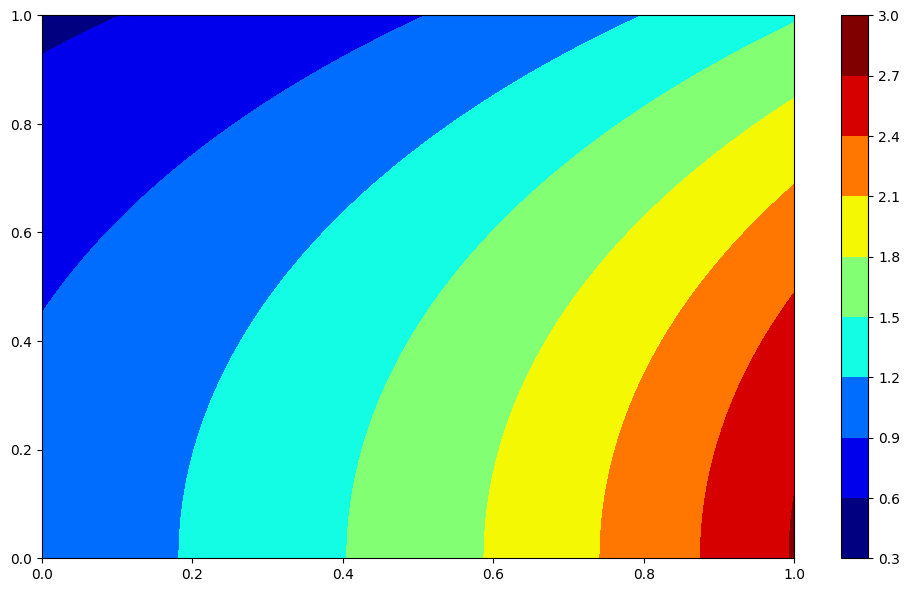

In [12]:
DrawFunction2D(uh, contour=False)
DrawFunction2D(uh, contour=True)

Here we also visualize the exact solution
$$ u(x,y)=\mathrm{e}^x \cos{(y)} $$ 

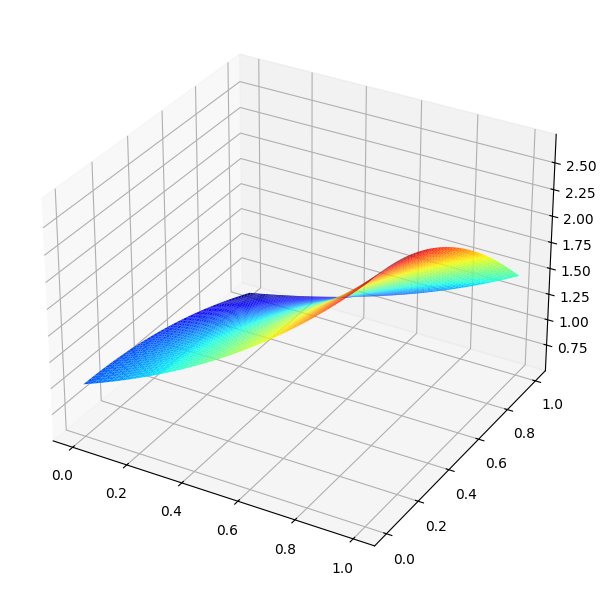

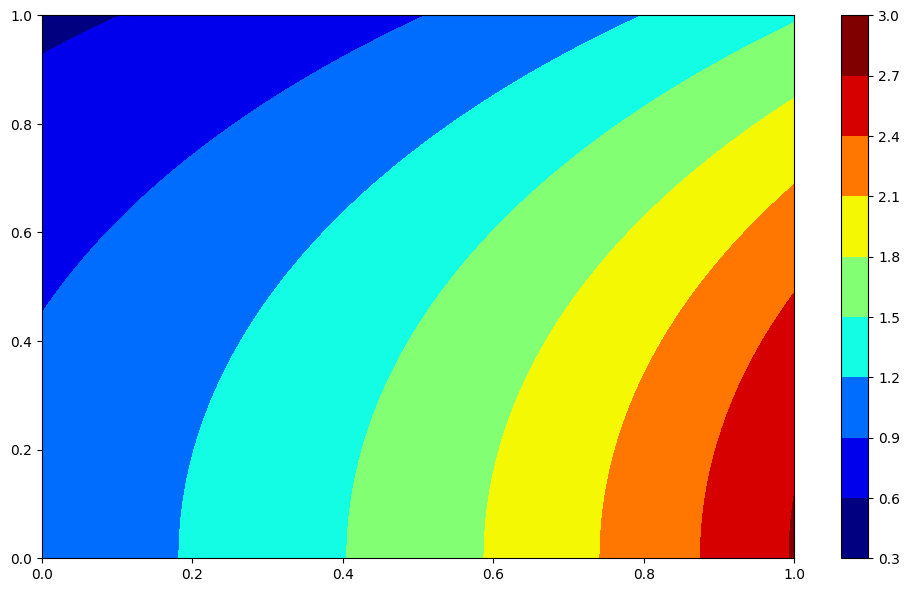

In [13]:
from methodsnm.forms import compute_difference_L2
from numpy import exp,cosh
uex =  GlobalFunction(lambda x: exp(x[0])*cos(x[1]), mesh = mesh)

DrawFunction2D(uex, contour=False)
DrawFunction2D(uex, contour=True)

The L2-error is given by

In [14]:
l2diff = compute_difference_L2(uh, uex, mesh, intorder = 6)
print("l2diff =", l2diff)

l2diff = 1.8674407956984686e-06
